In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_raw_data(file_path):
    liq_data = pd.read_csv(file_path)
    liq_data = liq_data[~(liq_data == '#VALUE!').any(axis=1)]
    for col in ['Open', 'ASKHI', 'BIDLO', 'Close', 'PRC', 'Volume', 'RET', 'SHROUT', 'TP', 'vwretx']:
        liq_data[col] = pd.to_numeric(liq_data[col], errors='coerce')

    rolling_window = liq_data.rolling(window=5)
    liq_data['bidlo_min'] = rolling_window['BIDLO'].min()
    liq_data['askhi_max'] = rolling_window['ASKHI'].max()
    liq_data['vol_sum'] = rolling_window['Volume'].sum()
    liq_data['shrout_mean'] = rolling_window['SHROUT'].mean()
    liq_data['prc_mean'] = rolling_window['PRC'].mean()
    print(liq_data)
    return liq_data


def liquidity_ratio(liq_vol_all):

    liq_ratio = []
    for i in range(len(liq_vol_all)):
        liq_ratio.append(liq_vol_all['PRC'][i+1:i+6].sum() * liq_vol_all['Volume'][i+1:i+6].sum() /
                         (np.abs(liq_vol_all['PRC'][i+1:i+6].mean() - liq_vol_all['PRC'][i:i+5].mean())))
    liq_ratio = pd.DataFrame(liq_ratio)
    print('--------------------------')
    print('Ratio de Liquidité')
    print(liq_ratio)
    return liq_ratio


def hui_heubel_ratio(liq_vol_all):
    lhh = []
    for i in range(len(liq_vol_all)):
        lhh.append((liq_vol_all['PRC'][i:i+5].max() - liq_vol_all['PRC'][i:i+5].min()) /
                   liq_vol_all['PRC'][i:i+5].min() /
                   (liq_vol_all['Volume'][i:i+5].sum() /
                    liq_vol_all['SHROUT'][i:i+5].mean() *
                    liq_vol_all['PRC'][i:i+5].mean()))
    lhh = pd.DataFrame(lhh)
    print('--------------------------')
    print('Ratio Hui Heubel')
    print(lhh)
    return lhh


def turn_over_ratio(liq_vol_all):
    turnover_ratio = []
    for i in range(len(liq_vol_all)):
        turnover_ratio.append((1/liq_vol_all['Volume'].count()) *
                              (liq_vol_all['Volume'][i:i+1].sum() /
                               liq_vol_all['SHROUT'][i:i+1].sum()))
    turnover_ratio = pd.DataFrame(turnover_ratio)
    print('--------------------------')
    print('Turnover ratio')
    print(turnover_ratio)
    return turnover_ratio


if __name__ == '__main__':
    file_path = 'AMD.csv'
    liq_vol_all_ = load_raw_data(file_path)
    liq_ratio_ = liquidity_ratio(liq_vol_all_)
    lhh_ = hui_heubel_ratio(liq_vol_all_)
    turnover_ratio_ = turn_over_ratio(liq_vol_all_)




          Date        Open       ASKHI       BIDLO       Close         PRC  \
1     1/3/2020   48.029999   49.389999   47.540001   48.599998   48.599998   
2     1/6/2020   48.020000   48.860001   47.860001   48.389999   48.389999   
3     1/7/2020   49.349998   49.389999   48.040001   48.250000   48.250000   
4     1/8/2020   47.849998   48.299999   47.139999   47.830002   47.830002   
5     1/9/2020   48.939999   49.959999   48.389999   48.970001   48.970001   
..         ...         ...         ...         ...         ...         ...   
895  7/25/2023  111.139999  114.050003  111.000000  113.000000  113.000000   
896  7/26/2023  111.910004  112.360001  109.300003  110.089996  110.089996   
897  7/27/2023  111.790001  115.080002  110.510002  111.099998  111.099998   
898  7/28/2023  113.379997  114.860001  112.440002  112.959999  112.959999   
899  7/31/2023  114.160004  114.680000  112.349998  114.400002  114.400002   

       Volume       RET      SHROUT          TP    vwretx   bid

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_raw_data(file_path):
    liq_data = pd.read_csv(file_path)
    liq_data = liq_data[~(liq_data == '#VALUE!').any(axis=1)]

    rolling_five = []
    for i in range(len(liq_data)):
        rolling_five.append(liq_data[i:i+5].agg({'BIDLO': 'min',
                                                 'ASKHI': 'max',
                                                 'Volume': 'sum',
                                                 'SHROUT': 'mean',
                                                 'PRC': 'mean'}))
    rolling_five_df = pd.DataFrame(rolling_five)
    rolling_five_df.columns = ['bidlo_min', 'askhi_max', 'vol_sum', 'shrout_mean', 'prc_mean']
    liq_vol_all = pd.concat([liq_data, rolling_five_df], axis=1)
    return liq_vol_all


def percentage_quoted_and_effective_bid_ask_spread(liq_vol_all):

    mid_price = (liq_vol_all.ASKHI + liq_vol_all.BIDLO) / 2

    percent_quote_ba = (liq_vol_all.ASKHI - liq_vol_all.BIDLO) / mid_price
    percent_effective_ba = 2 * abs((liq_vol_all.PRC - mid_price)) / mid_price
    print('--------------------------')
    print('Ecart de Cotation')
    print(percent_quote_ba)
    print('--------------------------')
    print('Ecart d"execution')
    print(percent_effective_ba)
    return percent_quote_ba, percent_effective_ba


def rolls_spread_estimate(liq_vol_all):
    price_diff = liq_vol_all.PRC.diff()
    price_diff.dropna(inplace=True)

    roll = []
    for i in range(len(price_diff)-5):
        roll_cov = np.cov(price_diff[i:i+5], price_diff[i+1:i+6])
        if roll_cov[0, 1] < 0:
            roll.append(2 * np.sqrt(-roll_cov[0, 1]))
        else:
            roll.append(2 * np.sqrt(np.abs(roll_cov[0, 1])))
    roll = pd.DataFrame(roll)
    print('--------------------------')
    print('Ecart de Roulement')
    print(roll)
    return roll


def corwin_schultz_spread(liq_vol_all):
    global beta_array, gamma_array
    gamma = []
    for i in range(len(liq_vol_all)-1):
        gamma.append((max(liq_vol_all['ASKHI'].iloc[i+1],
                          liq_vol_all['ASKHI'].iloc[i]) -
                      min(liq_vol_all['BIDLO'].iloc[i+1],
                          liq_vol_all['BIDLO'].iloc[i])) ** 2)
        gamma_array = np.array(gamma)

    beta = []
    for i in range(len(liq_vol_all)-1):
        beta.append((liq_vol_all['ASKHI'].iloc[i+1] - liq_vol_all['BIDLO'].iloc[i+1]) ** 2 +
                    (liq_vol_all['ASKHI'].iloc[i] - liq_vol_all['BIDLO'].iloc[i]) ** 2)
        beta_array = np.array(beta)

    alpha = ((np.sqrt(2 * beta_array) - np.sqrt(beta_array)) / (3 - (2 * np.sqrt(2)))) - np.sqrt(gamma_array / (3 - (2 * np.sqrt(2))))
    cs_spread = (2 * np.exp(alpha - 1)) / (1 + np.exp(alpha))
    cs_spread = pd.DataFrame(cs_spread)
    print('--------------------------')
    print('Écart de Corwin-Schultz ')
    print(cs_spread)
    return cs_spread


if __name__ == '__main__':
    liq_vol_all_ = load_raw_data('AMD.csv')
    percent_quote_ba_, percent_effective_ba_ = percentage_quoted_and_effective_bid_ask_spread(liq_vol_all_)
    roll_ = rolls_spread_estimate(liq_vol_all_)
    cs_spread_ = corwin_schultz_spread(liq_vol_all_)

--------------------------
Ecart de Cotation
1      0.038172
2      0.020678
3      0.027712
4      0.024308
5      0.031927
         ...   
896    0.027610
897    0.040516
898    0.021293
899    0.020526
0           NaN
Length: 900, dtype: float64
--------------------------
Ecart d"execution
1      0.005571
2      0.001241
3      0.019091
4      0.004610
5      0.008337
         ...   
896    0.013354
897    0.030055
898    0.012143
899    0.015593
0           NaN
Length: 900, dtype: float64
--------------------------
Ecart de Roulement
            0
0    1.317439
1    1.451319
2    1.531615
3    1.254275
4    0.653909
..        ...
888  1.767378
889  3.051675
890  3.767331
891  3.067197
892  2.770050

[893 rows x 1 columns]
--------------------------
Écart de Corwin-Schultz 
            0
0    0.476851
1    0.433784
2    0.178981
3    0.080597
4    0.399770
..        ...
894  0.192559
895  0.248014
896  0.596124
897  0.651883
898       NaN

[899 rows x 1 columns]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_raw_data(file_path):
    liq_data = pd.read_csv(file_path)
    liq_data = liq_data[~(liq_data == '#VALUE!').any(axis=1)]
    liq_data['RET'] = pd.to_numeric(liq_data['RET'])

    rolling_five = []
    for i in range(len(liq_data)):
        rolling_five.append(liq_data[i:i+5].agg({'BIDLO': 'min',
                                                 'ASKHI': 'max',
                                                 'Volume': 'sum',
                                                 'SHROUT': 'mean',
                                                 'PRC': 'mean'}))
    rolling_five_df = pd.DataFrame(rolling_five)
    rolling_five_df.columns = ['bidlo_min', 'askhi_max', 'vol_sum', 'shrout_mean', 'prc_mean']
    liq_vol_all = pd.concat([liq_data, rolling_five_df], axis=1)
    print(liq_vol_all)
    return liq_vol_all


def amihud_illiquidity(liq_vol_all):
    dvol = []
    for i in range(len(liq_vol_all)):
        dvol.append((liq_vol_all['PRC'][i:i+5] * liq_vol_all['Volume'][i:i+5]).sum())
    dvol = pd.DataFrame(dvol)

    amihud = []
    for i in range(len(liq_vol_all)):
        amihud.append((1 / liq_vol_all['RET'].count()) *
                      (np.sum(np.abs(liq_vol_all['RET'][i:i+1])) /
                       np.sum(dvol[i:i+1])))
    amihud = pd.DataFrame(amihud)
    print('--------------------------')
    print('Mesure d"illiquidité d"Amihud ')
    print(amihud)
    return amihud


def return_to_turnover(liq_vol_all):
    turnover_ratio = []
    for i in range(len(liq_vol_all)):
        turnover_ratio.append((1 / liq_vol_all['Volume'].count()) *
                              (liq_vol_all['Volume'][i:i + 1].sum() /
                               liq_vol_all['SHROUT'][i:i + 1].sum()))
    florackis = []
    for i in range(len(liq_vol_all)):
        florackis.append((1 / liq_vol_all['RET'].count()) *
                         (np.sum(np.abs(liq_vol_all['RET'][i:i+1]) /
                                 turnover_ratio[i:i+1])))
    florackis = pd.DataFrame(florackis)
    print('--------------------------')
    print('Retour sur le Volume d"Échanges')
    print(florackis)
    return florackis


def coefficient_of_elasticity(liq_vol_all):

    vol_diff_pct = liq_vol_all['Volume'].diff().pct_change()

    price_diff_pct = liq_vol_all['PRC'].diff().pct_change()

    cet = []
    for i in range(len(liq_vol_all)):
        cet.append(np.sum(vol_diff_pct[i:i+1]) /
                   np.sum(price_diff_pct[i:i+1]))
    cet = pd.DataFrame(cet)
    print('--------------------------')
    print('Coefficient d’élasticité  ')
    print(cet)
    return cet


if __name__ == '__main__':
    liq_vol_all_ = load_raw_data('AMD.csv')
    amihud_ = amihud_illiquidity(liq_vol_all_)
    florackis_ = return_to_turnover(liq_vol_all_)
    cet_ = coefficient_of_elasticity(liq_vol_all_)

    cet_ = coefficient_of_elasticity(liq_vol_all_)

    # Calculer la moyenne
    moyenne_cet = cet_.mean()
    print("La moyenne du coefficient d'élasticité est :", moyenne_cet)

          Date        Open       ASKHI       BIDLO       Close         PRC  \
1     1/3/2020   48.029999   49.389999   47.540001   48.599998   48.599998   
2     1/6/2020   48.020000   48.860001   47.860001   48.389999   48.389999   
3     1/7/2020   49.349998   49.389999   48.040001   48.250000   48.250000   
4     1/8/2020   47.849998   48.299999   47.139999   47.830002   47.830002   
5     1/9/2020   48.939999   49.959999   48.389999   48.970001   48.970001   
..         ...         ...         ...         ...         ...         ...   
896  7/26/2023  111.910004  112.360001  109.300003  110.089996  110.089996   
897  7/27/2023  111.790001  115.080002  110.510002  111.099998  111.099998   
898  7/28/2023  113.379997  114.860001  112.440002  112.959999  112.959999   
899  7/31/2023  114.160004  114.680000  112.349998  114.400002  114.400002   
0          NaN         NaN         NaN         NaN         NaN         NaN   

         Volume       RET        SHROUT            TP        vw

<ipython-input-17-87f15fefc00e>:47: RuntimeWarning: invalid value encountered in scalar divide
  (liq_vol_all['Volume'][i:i + 1].sum() /


--------------------------
Retour sur le Volume d"Échanges
            0
0    0.170447
1    0.110334
2    0.060991
3    0.198160
4    0.381286
..        ...
895  0.810084
896  0.211192
897  0.490558
898  0.382762
899  0.000000

[900 rows x 1 columns]


<ipython-input-17-87f15fefc00e>:69: RuntimeWarning: invalid value encountered in scalar divide
  cet.append(np.sum(vol_diff_pct[i:i+1]) /


--------------------------
Coefficient d’élasticité  
            0
0         NaN
1         NaN
2    4.205875
3   -0.712035
4    1.695239
..        ...
895  5.049845
896 -1.325445
897 -2.138013
898  4.037322
899       NaN

[900 rows x 1 columns]


<ipython-input-17-87f15fefc00e>:69: RuntimeWarning: invalid value encountered in scalar divide
  cet.append(np.sum(vol_diff_pct[i:i+1]) /


--------------------------
Coefficient d’élasticité  
            0
0         NaN
1         NaN
2    4.205875
3   -0.712035
4    1.695239
..        ...
895  5.049845
896 -1.325445
897 -2.138013
898  4.037322
899       NaN

[900 rows x 1 columns]
La moyenne du coefficient d'élasticité est : 0   -1.593155
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


def load_raw_data(file_path):
    liq_data = pd.read_csv(file_path)
    liq_data = liq_data[~(liq_data == '#VALUE!').any(axis=1)]
    for col in ['Open', 'ASKHI', 'BIDLO', 'Close', 'PRC', 'Volume', 'RET', 'SHROUT', 'TP', 'vwretx']:
        liq_data[col] = pd.to_numeric(liq_data[col], errors='coerce')

    rolling_window = liq_data.rolling(window=5)
    liq_data['bidlo_min'] = rolling_window['BIDLO'].min()
    liq_data['askhi_max'] = rolling_window['ASKHI'].max()
    liq_data['vol_sum'] = rolling_window['Volume'].sum()
    liq_data['shrout_mean'] = rolling_window['SHROUT'].mean()
    liq_data['prc_mean'] = rolling_window['PRC'].mean()
    return liq_data


def market_based_measures(liq_vol_all):
    liq_vol_all = liq_vol_all.dropna(subset=['vwretx', 'RET', 'Volume'])
    vol_pct_change = liq_vol_all['Volume'].pct_change().dropna()

    X1 = sm.add_constant(liq_vol_all['vwretx'])
    y1 = liq_vol_all['RET']
    ols1 = sm.OLS(y1, X1).fit()
    unsys_resid = ols1.resid

    unsys_resid = unsys_resid.iloc[1:]

    X2 = sm.add_constant(vol_pct_change)
    y2 = unsys_resid ** 2
    ols2 = sm.OLS(y2, X2).fit()
    market_impact = ols2.resid
    market_impact = pd.DataFrame(market_impact)
    return ols2.summary(), market_impact


if __name__ == '__main__':
    liq_vol_all_ = load_raw_data('AMD.csv')
    market_impact_summary, market_impact_ = market_based_measures(liq_vol_all_)
    print(market_impact_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     46.19
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           1.95e-11
Time:                        13:56:58   Log-Likelihood:                 4258.4
No. Observations:                 898   AIC:                            -8513.
Df Residuals:                     896   BIC:                            -8503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010    7.1e-05     14.638      0.0

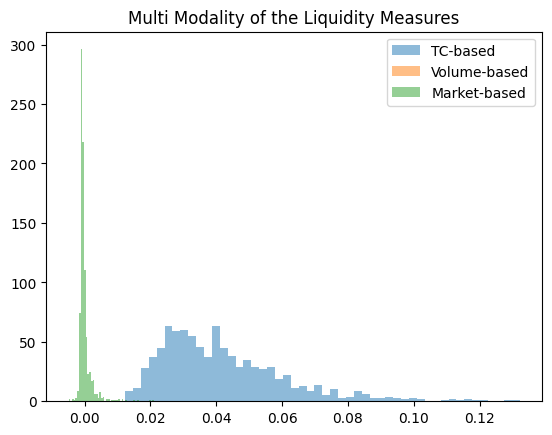

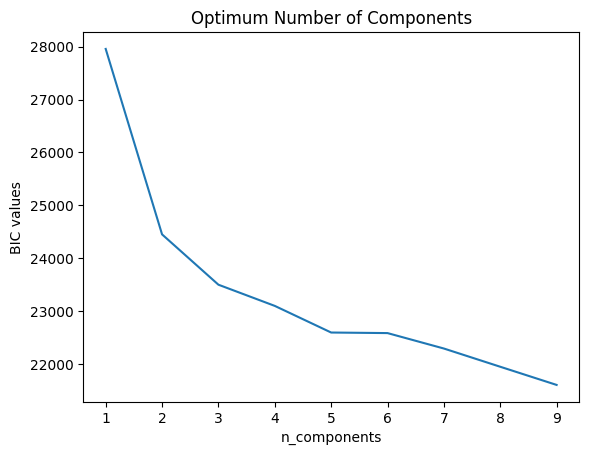

state-3 is likely to occur with a probability of 0.495125
State probabilities are [0.05489891 0.44997611 0.49512497]


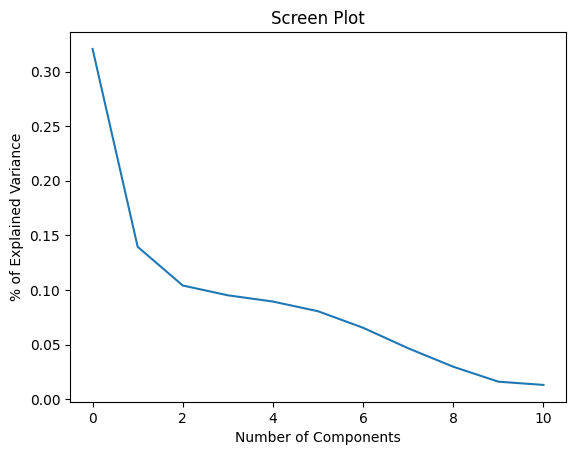

State probabilities are [0.6757251 0.3242749]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The state 3 is likely to occur
State probabilities based on GMCM are [0.23852184 0.37290034 0.38857783]


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copulae.mixtures.gmc.gmc import GaussianMixtureCopula

def load_raw_data(file_path):
    liq_data = pd.read_csv(file_path)
    liq_data = liq_data[~(liq_data == '#VALUE!').any(axis=1)]
    for col in ['Open', 'ASKHI', 'BIDLO', 'Close', 'PRC', 'Volume', 'RET', 'SHROUT', 'TP', 'vwretx']:
        liq_data[col] = pd.to_numeric(liq_data[col], errors='coerce')

    rolling_window = liq_data.rolling(window=5)
    liq_data['bidlo_min'] = rolling_window['BIDLO'].min()
    liq_data['askhi_max'] = rolling_window['ASKHI'].max()
    liq_data['vol_sum'] = rolling_window['Volume'].sum()
    liq_data['shrout_mean'] = rolling_window['SHROUT'].mean()
    liq_data['prc_mean'] = rolling_window['PRC'].mean()
    return liq_data


def percentage_quoted_and_effective_bid_ask_spread(liq_vol_all):

    mid_price = (liq_vol_all.ASKHI + liq_vol_all.BIDLO) / 2

    percent_quote_ba = (liq_vol_all.ASKHI - liq_vol_all.BIDLO) / mid_price
    percent_effective_ba = 2 * abs((liq_vol_all.PRC - mid_price)) / mid_price

    return percent_quote_ba, percent_effective_ba


def rolls_spread_estimate(liq_vol_all):
    price_diff = liq_vol_all.PRC.diff()
    price_diff.dropna(inplace=True)

    roll = []
    for i in range(len(price_diff)-5):
        roll_cov = np.cov(price_diff[i:i+5], price_diff[i+1:i+6])
        if roll_cov[0, 1] < 0:
            roll.append(2 * np.sqrt(-roll_cov[0, 1]))
        else:
            roll.append(2 * np.sqrt(np.abs(roll_cov[0, 1])))
    roll = pd.DataFrame(roll)

    return roll


def corwin_schultz_spread(liq_vol_all):
    global beta_array, gamma_array
    gamma = []
    for i in range(len(liq_vol_all)-1):
        gamma.append((max(liq_vol_all['ASKHI'].iloc[i+1],
                          liq_vol_all['ASKHI'].iloc[i]) -
                      min(liq_vol_all['BIDLO'].iloc[i+1],
                          liq_vol_all['BIDLO'].iloc[i])) ** 2)
        gamma_array = np.array(gamma)

    beta = []
    for i in range(len(liq_vol_all)-1):
        beta.append((liq_vol_all['ASKHI'].iloc[i+1] - liq_vol_all['BIDLO'].iloc[i+1]) ** 2 +
                    (liq_vol_all['ASKHI'].iloc[i] - liq_vol_all['BIDLO'].iloc[i]) ** 2)
        beta_array = np.array(beta)

    alpha = ((np.sqrt(2 * beta_array) - np.sqrt(beta_array)) / (3 - (2 * np.sqrt(2)))) - np.sqrt(gamma_array / (3 - (2 * np.sqrt(2))))
    cs_spread = (2 * np.exp(alpha - 1)) / (1 + np.exp(alpha))
    cs_spread = pd.DataFrame(cs_spread)
    return cs_spread

def liquidity_ratio(liq_vol_all):
    liq_ratio = []
    for i in range(len(liq_vol_all)):
        liq_ratio.append(liq_vol_all['PRC'][i+1:i+6].sum() * liq_vol_all['Volume'][i+1:i+6].sum() /
                         (np.abs(liq_vol_all['PRC'][i+1:i+6].mean() - liq_vol_all['PRC'][i:i+5].mean())))
    liq_ratio = pd.DataFrame(liq_ratio)

    return liq_ratio


def hui_heubel_ratio(liq_vol_all):
    lhh = []
    for i in range(len(liq_vol_all)):
        lhh.append((liq_vol_all['PRC'][i:i+5].max() - liq_vol_all['PRC'][i:i+5].min()) /
                   liq_vol_all['PRC'][i:i+5].min() /
                   (liq_vol_all['Volume'][i:i+5].sum() /
                    liq_vol_all['SHROUT'][i:i+5].mean() *
                    liq_vol_all['PRC'][i:i+5].mean()))
    lhh = pd.DataFrame(lhh)
    return lhh


def turn_over_ratio(liq_vol_all):
    turnover_ratio = []
    for i in range(len(liq_vol_all)):
        turnover_ratio.append((1/liq_vol_all['Volume'].count()) *
                              (liq_vol_all['Volume'][i:i+1].sum() /
                               liq_vol_all['SHROUT'][i:i+1].sum()))
    turnover_ratio = pd.DataFrame(turnover_ratio)
    return turnover_ratio


def amihud_illiquidity(liq_vol_all):
    dvol = []
    for i in range(len(liq_vol_all)):
        dvol.append((liq_vol_all['PRC'][i:i+5] * liq_vol_all['Volume'][i:i+5]).sum())
    dvol = pd.DataFrame(dvol)

    amihud = []
    for i in range(len(liq_vol_all)):
        amihud.append((1 / liq_vol_all['RET'].count()) *
                      (np.sum(np.abs(liq_vol_all['RET'][i:i+1])) /
                       np.sum(dvol[i:i+1])))
    amihud = pd.DataFrame(amihud)

    return amihud


def return_to_turnover(liq_vol_all):
    turnover_ratio = []
    for i in range(len(liq_vol_all)):
        turnover_ratio.append((1 / liq_vol_all['Volume'].count()) *
                              (liq_vol_all['Volume'][i:i + 1].sum() /
                               liq_vol_all['SHROUT'][i:i + 1].sum()))
    florackis = []
    for i in range(len(liq_vol_all)):
        florackis.append((1 / liq_vol_all['RET'].count()) *
                         (np.sum(np.abs(liq_vol_all['RET'][i:i+1]) /
                                 turnover_ratio[i:i+1])))
    florackis = pd.DataFrame(florackis)

    return florackis


def coefficient_of_elasticity(liq_vol_all):
    vol_diff_pct = liq_vol_all['Volume'].diff().pct_change().dropna()
    price_diff_pct = liq_vol_all['PRC'].diff().pct_change().dropna()
    cet = []
    for i in range(len(vol_diff_pct)):
        vol_pct = vol_diff_pct.iloc[i]
        price_pct = price_diff_pct.iloc[i]
        if np.isnan(vol_pct) or np.isnan(price_pct):
            cet.append(np.nan)
            continue
        constant = 1e-9
        elasticity = vol_pct / (price_pct + constant)
        cet.append(elasticity)
    cet_df = pd.DataFrame(cet, columns=['Elasticity'])
    return cet_df

def market_based_measures(liq_vol_all):
    liq_vol_all = liq_vol_all.dropna(subset=['vwretx', 'RET', 'Volume'])
    vol_pct_change = liq_vol_all['Volume'].pct_change().dropna()

    X1 = sm.add_constant(liq_vol_all['vwretx'])
    y1 = liq_vol_all['RET']
    ols1 = sm.OLS(y1, X1).fit()
    unsys_resid = ols1.resid

    unsys_resid = unsys_resid.iloc[1:]

    X2 = sm.add_constant(vol_pct_change)
    y2 = unsys_resid ** 2
    ols2 = sm.OLS(y2, X2).fit()
    market_impact = ols2.resid

    return ols2.summary(), market_impact


def all_liquidity_measures(percent_quote_ba, percent_effective_ba, roll, cs_spread, liq_ratio, lhh, turnover_ratio, amihud, florackis, cet, market_impact):
    liq_measures_dict = {
        'Percent_Quoted_BA': percent_quote_ba,
        'Percent_Effective_BA': percent_effective_ba,
        'Roll': roll,
        'CS_Spread': cs_spread,
        'Liq_Ratio': liq_ratio,
        'LHH': lhh,
        'Turnover_Ratio': turnover_ratio,
        'Amihud': amihud,
        'Florackis': florackis,
        'CET': cet,
        'Market_Impact': market_impact
    }
    liq_measures_all = pd.concat(liq_measures_dict, axis=1)
    liq_measures_all.dropna(how='all', inplace=True)
    summary_stats = liq_measures_all.describe().T
    return liq_measures_all, summary_stats
    print(liq-_measure_all)

def cluster_test(liq_measures_all):
    liq_measures_all2 = liq_measures_all.dropna()
    scaled_liq = StandardScaler().fit_transform(liq_measures_all2)

    kwargs = dict(alpha=0.5, bins=50, stacked=True)
    plt.hist(liq_measures_all.loc[:, 'Percent_Quoted_BA'],
             **kwargs, label='TC-based')
    plt.hist(liq_measures_all.loc[:, 'Turnover_Ratio'],
             **kwargs, label='Volume-based')
    plt.hist(liq_measures_all.loc[:, 'Market_Impact'],
             **kwargs, label='Market-based')
    plt.title('Multi Modality of the Liquidity Measures')
    plt.legend()
    plt.show()

    n_components = np.arange(1, 10)
    clusters = [GaussianMixture(n, covariance_type='spherical', random_state=0).fit(scaled_liq)
                for n in n_components]
    plt.plot(n_components, [m.bic(scaled_liq) for m in clusters])
    plt.title('Optimum Number of Components')
    plt.xlabel('n_components')
    plt.ylabel('BIC values')
    plt.show()

    return scaled_liq


def cluster_state(scaled_liq, nstates):
    gmm = GaussianMixture(n_components=nstates,
                          covariance_type='spherical',
                          init_params='kmeans')

    gmm_fit = gmm.fit(scaled_liq)
    labels = gmm_fit.predict(scaled_liq)
    state_probs = gmm.predict_proba(scaled_liq)
    state_probs_df = pd.DataFrame(state_probs, columns=['state-1', 'state-2', 'state-3'])
    state_probs_means = [state_probs_df.iloc[:, i].mean() for i in range(len(state_probs_df.columns))]

    if np.max(state_probs_means) == state_probs_means[0]:
        print('state-1 is likely to occur with a probability of {:4f}'.format(state_probs_means[0]))
    elif np.max(state_probs_means) == state_probs_means[1]:
        print('state-2 is likely to occur with a probability of {:4f}'.format(state_probs_means[1]))
    else:
        print('state-3 is likely to occur with a probability of {:4f}'.format(state_probs_means[2]))
    return state_probs


def pca_test(scaled_liq):
    pca = PCA(n_components=11)
    components = pca.fit_transform(scaled_liq)
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Screen Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('% of Explained Variance')
    plt.show()

def gmm_pca(scaled_liq):
    pca= PCA(n_components=2)
    components = pca.fit_transform(scaled_liq)
    mxtd = GaussianMixture(n_components=2, covariance_type='spherical')
    gmm = mxtd.fit(components)
    labels = gmm.predict(components)
    state_probs = gmm.predict_proba(components)
    return state_probs, pca


def gmcm_test(scaled_liq):
    _, dim = scaled_liq.shape
    gmcm = GaussianMixtureCopula(n_clusters=3, ndim=dim)
    gmcm_fit = gmcm.fit(scaled_liq,method='kmeans', criteria='GMCM', eps=0.0001)
    state_probs = gmcm_fit.params.prob
    print(f'The state {np.argmax(state_probs) + 1} is likely to occur')
    print(f'State probabilities based on GMCM are {state_probs}')


if __name__ == '__main__':
    file_path = 'AMD.csv'
    liq_vol_all_ = load_raw_data(file_path)
    percent_quote_ba_, percent_effective_ba_ = percentage_quoted_and_effective_bid_ask_spread(liq_vol_all_)
    roll_ = rolls_spread_estimate(liq_vol_all_)
    cs_spread_ = corwin_schultz_spread(liq_vol_all_)
    liq_ratio_ = liquidity_ratio(liq_vol_all_)
    lhh_ = hui_heubel_ratio(liq_vol_all_)
    turnover_ratio_ = turn_over_ratio(liq_vol_all_)
    amihud_ = amihud_illiquidity(liq_vol_all_)
    florackis_ = return_to_turnover(liq_vol_all_)
    cet_ = coefficient_of_elasticity(liq_vol_all_)
    market_impact_summary, market_impact_ = market_based_measures(liq_vol_all_)
    liq_measures_all_, summary_ = all_liquidity_measures(percent_quote_ba_, percent_effective_ba_, roll_, cs_spread_, liq_ratio_, lhh_, turnover_ratio_, amihud_, florackis_, cet_, market_impact_)
    scaled_liq_ = cluster_test(liq_measures_all_)
    state_probs_ = cluster_state(scaled_liq_, nstates=3)
    print(f'State probabilities are {state_probs_.mean(axis=0)}')
    pca_test(scaled_liq_)
    state_probs__, pca_ = gmm_pca(scaled_liq_)
    print(f'State probabilities are {state_probs__.mean(axis=0)}')
    loadings = pca_.components_.T * np.sqrt(pca_.explained_variance_ratio_)
    loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=liq_measures_all_.columns)
    gmcm_test(scaled_liq_)

In [ ]:
!pip install copulae

In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Chargement des données historiques sur les spreads de liquidité
# Assurez-vous que le fichier csv contient les colonnes "Date" et "Spread" par exemple
data = pd.read_csv(file_path)

# Exploration rapide des données
print(data.head())
data = data.head(893)
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Convertir les dates en nombres flottants représentant les jours depuis une date de référence
data['Date'] = data['Date'].apply(lambda x: (x - datetime(2000, 1, 1)).total_seconds() / (60 * 60 * 24))



# Séparation des features (X) et de la variable cible (y)
X = data['Date'].values.reshape(-1, 1)
y = roll_

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
predictions = model.predict(X_test)

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# Exemple de prédiction pour une date future
date_future = np.array([(datetime(2024, 5, 15) - datetime(2000, 1, 1)).total_seconds() / (60 * 60 * 24)])  # Remplacez avec la date future souhaitée
spread_future = model.predict(date_future.reshape(-1, 1))
print("Spread prédit pour la date future:", spread_future)

       Date       Open      ASKHI      BIDLO      Close        PRC    Volume  \
0  1/2/2020  46.860001  49.250000  46.630001  49.099998  49.099998  80331100   
1  1/3/2020  48.029999  49.389999  47.540001  48.599998  48.599998  73127400   
2  1/6/2020  48.020000  48.860001  47.860001  48.389999  48.389999  47934900   
3  1/7/2020  49.349998  49.389999  48.040001  48.250000  48.250000  58061400   
4  1/8/2020  47.849998  48.299999  47.139999  47.830002  47.830002  53767000   

            RET      SHROUT          TP        vwretx  
0       #VALUE!  1224000000  3882134266       #VALUE!  
1    -0.0101833  1224000000  3547410125  -0.086221681  
2  -0.004320967  1224000000  2318611129  -0.346393271  
3  -0.002893139  1224000000  2819461584   0.216013133  
4  -0.008704622  1224000000  2567732697  -0.089282609  
RMSE: 2.0202527745224206
Spread prédit pour la date future: [[3.34474633]]


In [ ]:


# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Chargement des données historiques sur les spreads de liquidité
# Assurez-vous que le fichier csv contient les colonnes "Date" et "Spread" par exemple
data = pd.read_csv(file_path)

# Exploration rapide des données
print(data.head())
data = data.head(893)
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Convertir les dates en nombres flottants représentant les jours depuis une date de référence
data['Date'] = data['Date'].apply(lambda x: (x - datetime(2000, 1, 1)).total_seconds() / (60 * 60 * 24))



# Séparation des features (X) et de la variable cible (y)
X = data['Date'].values.reshape(-1, 1)
y = roll_

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

# Initialisation du modèle K-Means avec 5 clusters (vous pouvez ajuster ce nombre)
kmeans = KMeans(n_clusters=2, random_state=42)

# Entraînement du modèle K-Means
kmeans.fit(X_train)

# Prédiction des clusters pour les données de test
clusters = kmeans.predict(X_test)


# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# Exemple de prédiction pour une date future
date_future = np.array([(datetime(2024, 5, 15) - datetime(2000, 1, 1)).total_seconds() / (60 * 60 * 24)])  # Remplacez avec la date future souhaitée
spread_future = model.predict(date_future.reshape(-1, 1))
print("Spread prédit pour la date future:", spread_future)

       Date       Open      ASKHI      BIDLO      Close        PRC    Volume  \
0  1/2/2020  46.860001  49.250000  46.630001  49.099998  49.099998  80331100   
1  1/3/2020  48.029999  49.389999  47.540001  48.599998  48.599998  73127400   
2  1/6/2020  48.020000  48.860001  47.860001  48.389999  48.389999  47934900   
3  1/7/2020  49.349998  49.389999  48.040001  48.250000  48.250000  58061400   
4  1/8/2020  47.849998  48.299999  47.139999  47.830002  47.830002  53767000   

            RET      SHROUT          TP        vwretx  
0       #VALUE!  1224000000  3882134266       #VALUE!  
1    -0.0101833  1224000000  3547410125  -0.086221681  
2  -0.004320967  1224000000  2318611129  -0.346393271  
3  -0.002893139  1224000000  2819461584   0.216013133  
4  -0.008704622  1224000000  2567732697  -0.089282609  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RMSE: 2.0202527745224206
Spread prédit pour la date future: [[3.34474633]]
